# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lrcv'
feature_name = 'polyfeature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Polynomial Feature 생성

In [6]:
df = pd.read_csv(feature_dir / 'feature.csv', index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(df.drop(target_col, axis=1)))
feature_names = poly.get_feature_names(df.columns)
feature_names

['1',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'airmass_u',
 'class',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'z^2',
 'z redshift',
 'z dered_u',
 'z dered_g',
 'z dered_r',
 'z dered_i',
 'z dered_z',
 'z nObserve',
 'z airmass_u',
 'z class',
 'z d_dered_u',
 'z d_dered_g',
 'z d_dered_r',
 'z d_dered_i',
 'z d_dered_z',
 'z d_dered_ig',
 'z d_dered_zg',
 'z d_dered_rz',
 'z d_dered_iz',
 'redshift^2',
 'redshift dered_u',
 'redshift dered_g',
 'redshift dered_r',
 'redshift dered_i',
 'redshift dered_z',
 'redshift nObserve',
 'redshift airmass_u',
 'redshift class',
 'redshift d_dered_u',
 'redshift d_dered_g',
 'redshift d_dered_r',
 'redshift d_dered_i',
 'redshift d_dered_z',
 'redshift d_dered_ig',
 'redshift d_dered_zg',
 'redshift d_dered_rz',
 'redshift d_dered_iz',
 'dered_u^2',
 'dered_u dered_g',
 'dered_u dered_r',
 'dered_u dered

In [8]:
df_poly = pd.DataFrame(data=X, columns=feature_names, index=df.index)
df_poly[target_col] = df[target_col]
df_poly.head()
df_poly.to_csv(feature_file)

In [9]:
del df_poly, df

In [10]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 210)


,1,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,z^2,z redshift,z dered_u,z dered_g,z dered_r,z dered_i,z dered_z,z nObserve,z airmass_u,z class,z d_dered_u,z d_dered_g,z d_dered_r,z d_dered_i,z d_dered_z,z d_dered_ig,z d_dered_zg,z d_dered_rz,z d_dered_iz,redshift^2,redshift dered_u,redshift dered_g,redshift dered_r,redshift dered_i,redshift dered_z,redshift nObserve,redshift airmass_u,redshift class,redshift d_dered_u,redshift d_dered_g,...,class d_dered_z,class d_dered_ig,class d_dered_zg,class d_dered_rz,class d_dered_iz,d_dered_u^2,d_dered_u d_dered_g,d_dered_u d_dered_r,d_dered_u d_dered_i,d_dered_u d_dered_z,d_dered_u d_dered_ig,d_dered_u d_dered_zg,d_dered_u d_dered_rz,d_dered_u d_dered_iz,d_dered_g^2,d_dered_g d_dered_r,d_dered_g d_dered_i,d_dered_g d_dered_z,d_dered_g d_dered_ig,d_dered_g d_dered_zg,d_dered_g d_dered_rz,d_dered_g d_dered_iz,d_dered_r^2,d_dered_r d_dered_i,d_dered_r d_dered_z,d_dered_r d_dered_ig,d_dered_r d_dered_zg,d_dered_r d_dered_rz,d_dered_r d_dered_iz,d_dered_i^2,d_dered_i d_dered_z,d_dered_i d_dered_ig,d_dered_i d_dered_zg,d_dered_i d_dered_rz,d_dered_i d_dered_iz,d_dered_z^2,d_dered_z d_dered_ig,d_dered_z d_dered_zg,d_dered_z d_dered_rz,d_dered_z d_dered_iz,d_dered_ig^2,d_dered_ig d_dered_zg,d_dered_ig d_dered_rz,d_dered_ig d_dered_iz,d_dered_zg^2,d_dered_zg d_dered_rz,d_dered_zg d_dered_iz,d_dered_rz^2,d_dered_rz d_dered_iz,d_dered_iz^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0002,-0.1093,1.8170,0.1270,0.9086,0.0208,0.0011,1.6087,0.1200,0.0,0.0063,0.1783,-0.0002,0.0008,-0.0981,-0.0626,0.0367,0.0156,-1.3511,3.4181e-08,-2.0203e-05,0.0003,2.3488e-05,0.0002,3.8455e-06,2.0594e-07,0.0003,2.2191e-05,2.2235e-05,1.1669e-06,3.2960e-05,-3.7490e-08,1.4942e-07,-1.8144e-05,-1.1575e-05,6.7832e-06,2.8794e-06,-0.0002,0.0119,-0.1986,-0.0139,-0.0993,-0.0023,-0.0001,-0.1758,-0.0131,-0.0131,-0.0007,-0.0195,...,-0.0118,-0.0075,0.0044,0.0019,-0.1625,3.9834e-05,1.1252e-03,-1.2798e-06,5.1009e-06,-6.1941e-04,-3.9513e-04,2.3156e-04,9.8297e-05,-0.0085,0.0318,-3.6150e-05,1.4408e-04,-0.0175,-1.1161e-02,0.0065,2.7766e-03,-0.2409,4.1119e-08,-1.6389e-07,1.9901e-05,1.2695e-05,-7.4398e-06,-3.1582e-06,2.7398e-04,6.5318e-07,-7.9317e-05,-5.0598e-05,2.9652e-05,1.2587e-05,-1.0920e-03,9.6316e-03,6.1442e-03,-3.6007e-03,-1.5285e-03,0.1326,3.9195e-03,-2.2970e-03,-9.7505e-04,0.0846,1.3461e-03,5.7142e-04,-0.0496,2.4256e-04,-0.0210,1.8255
1,1.0,-0.0719,-0.1007,-2.4251,-0.2656,-2.8534,-0.1751,-0.1054,-0.8761,0.6658,1.0,0.0081,0.2144,0.0001,0.0007,0.0190,0.0156,-0.0133,-0.0071,0.5650,5.1738e-03,7.2464e-03,0.1744,1.9104e-02,0.2052,1.2597e-02,7.5809e-03,0.0630,-4.7893e-02,-1.4200e-02,-5.8349e-04,-1.5419e-02,-8.7153e-06,-5.1123e-05,-1.3637e-03,-1.1239e-03,9.5460e-04,5.0978e-04,-0.0406,0.0101,0.2443,0.0268,0.2875,0.0176,0.0106,0.0883,-0.0671,-0.0199,-0.0008,-0.0216,...,0.0037,0.0031,-0.0026,-0.0014,0.1115,6.5806e-05,1.7389e-03,9.8290e-07,5.7656e-06,1.5379e-04,1.2675e-04,-1.0766e-04,-5.7493e-05,0.0046,0.0460,2.5973e-05,1.5236e-04,0.0041,3.3493e-03,-0.0028,-1.5193e-03,0.1211,1.4681e-08,8.6118e-08,2.2971e-06,1.8932e-06,-1.6081e-06,-8.5874e-07,6.8457e-05,5.0517e-07,1.3475e-05,1.1105e-05,-9.4327e-06,-5.0373e-06,4.0156e-04,3.5943e-04,2.9622e-04,-2.5161e-04,-1.3437e-04,0.0107,2.4412e-04,-2.0736e-04,-1.1074e-04,0.0088,1.7613e-04,9.4060e-05,-0.0075,5.0230e-05,-0.0040,0.3192
2,1.0,-0.0302,-0.1082,-1.5717,-0.1600,-1.4768,-0.0822,-0.0444,-0.4286,-1.3179,0.0,0.0013,0.0650,-0.0015,0.0002,0.0444,0.0308,-0.0170,-0.0099,0.4877,9.1298e-04,3.2708e-03,0.0475,4.8338e-03,0.0446,2.4830e-03,1.3416e-03,0.0130,3.9822e-02,-1.9476e-03,-3.9487e-05,-1.9652e-03,4.4024e-05,-5.3424e-06,-1.3413e-03,-9.2915e-04,5.1426e-04,2.9778e-04,-0.0147,0.0117,0.1701,0.0173,0.1599,0.0089,0.0048,0.0464,0.1427,-0.0070,-0.0001,-0.0070,...,0.0029,0.0020,-0.0011,-0.0006,0.0314,1.7078e-06,8.4993e-05,-1.9

In [11]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 209) (80000, 209)


## Stratified K-Fold Cross Validation

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## Logistic Regression 모델 학습

In [20]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression(multi_class='multinomial')
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [21]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

89.6659%


In [22]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [23]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [24]:
clf.coef_.shape

(3, 209)

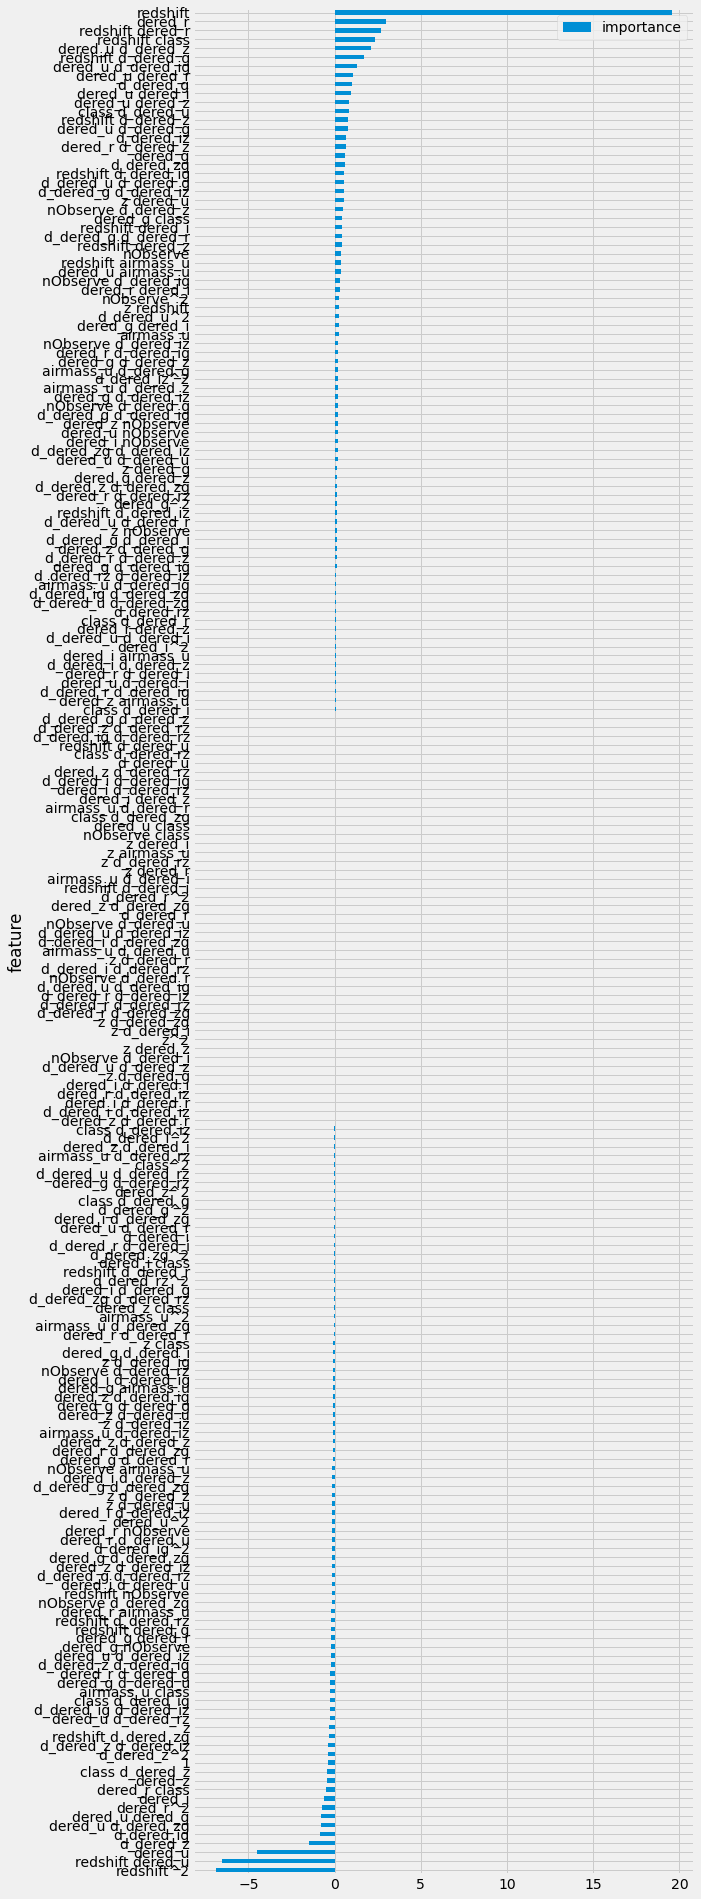

In [31]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.coef_[1, :].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(8, 32))

## 제출 파일 생성

In [32]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [36]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [37]:
sub[target_col].value_counts()

2    42870
0    31013
1     6117
Name: class, dtype: int64

In [38]:
sub.to_csv(sub_file)